<table>
<tr>
<td><img src="https://github.com/alistairboyer/DigitalFutures/blob/5fe56e553dfe455c312722832c5dd14a6da3f3a9/Swan%20Churn/WillowLogo.png?raw=True" width="200px" /></td>
<td>
<font size="20"><b>WILLOW</b>: <i>Data Analysis</i></font>
<ul>
<br />
<li>Alistair Boyer</li>
<br />
<li>Fátima González</li>
<br />
<li>Mary Petrichenko</li>
</ul>
</td>
<td><img src="https://github.com/alistairboyer/DigitalFutures/blob/38eb98f65a281778b4d61bcbd053d257e8d1ae64/Swan%20Churn/SwanLogo.png?raw=True" width="280px" /></td>
</tr>
</table>

---

# Deliverables
* Notebook
  - `Willow_Notebook.ipynb`
  - _this_ interactive python notebook containing data analysis and modelling details
  - graphical analysis of the key features of the dataset
* Information Deck
  - `Willow_SlideDeck.pdf`
  - pdf slide deck containing visualisations and insight
* 500 Most Churn At-Risk Customers
  - `Willow_500CustomerIDs.csv`
  - csv file containing 500 IDs of customers most at risk from churning
* Churn Score per Customer
  - `Willow_CustomerChurnScore.csv`
  - csv file containing all IDs of current customers and their liklihood score for churning
  -  score goes from 1 (lowest) to 10 (highest) risk of churn
  


---
# Setup

In [1]:
# @title Library Imports and Style Settings
# data
import pandas as pd
import numpy as np

# visualisation
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.graph_objects as go
# import dtreeviz  # not happy with colab

# modelling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import metrics
try:
    import tensorflow_decision_forests as tfdf
except ModuleNotFoundError:
    !pip install tensorflow_decision_forests
    import tensorflow_decision_forests as tfdf

# additional
import requests
import json
from collections import defaultdict
import re
import random
import datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 21.8 MB/s eta 0:00:00


In [2]:
# @title Style Settings
pd.options.display.max_columns=None

custom_colors = ["#02355B", "#8EC3B0", "#DFC2BC", "#FAC882", "#CD7E59", "#DFC2BC"]

sns.set_style(
    "darkgrid",
#    rc={'axes.facecolor': custom_colors[2]}
)

sns.set_palette(sns.color_palette(custom_colors))


label_kwargs = {
    "fontweight": "bold",
}
axhline_kwargs = {
    "color": sns.color_palette()[2],
    "linewidth": 2,
    "linestyle": "dotted",
}
custom_gradient = matplotlib.colors.LinearSegmentedColormap.from_list('custom_gradient', (
    (0.000, (0.557, 0.765, 0.690)),
    (0.500, (1.000, 1.000, 1.000)),
    (1.000, (0.008, 0.208, 0.357)),
))  # https://eltos.github.io/gradient/#8EC3B0-FFFFFF-02355B

In [3]:
# @title Treemap Function
def treemap(ax, df, x, y, *, dropna=False, fill_width=False, sorter=None, vsep=True, **barplotkwargs):
    """draw a treemap area plot of two (or one) features within a dataframe"""

    # initialise variables for labels
    column_labels = [x] if x==y else [x, y]
    count_label = f'{x}_{y}_count'
    x_label = f'{x}_copy' if x == y else x

    # calculate count crosstab
    value_counts = df[column_labels].value_counts(dropna=dropna, normalize=False).to_frame(count_label).reset_index()
    if x==y:
        # insert dummy column for single axis display
        value_counts.insert(loc=1, column=x_label, value='')

    # sort
    if sorter is not None:
        value_counts = sorter(value_counts)
    else:
        value_counts = value_counts.sort_values([x_label, y], ascending=False)

    # get groups
    groups = value_counts.groupby(x_label, dropna=False, sort=False)

    # calculate horizontal data
    width_scale = groups[count_label].sum().sum() if fill_width else len(df)
    widths = groups[count_label].sum() / width_scale
    xs = np.pad(widths, (1, 0,), constant_values=(0,))[:-1].cumsum() + widths / 2.0

    # iterate horizontally
    for (val, group), width, x in zip(groups, widths, xs):
        # calculate vertical data
        heights = group[count_label] / group[count_label].sum()
        bottoms = np.pad(heights, (1, 0,), constant_values=(0,))[:-1].cumsum()
        # reset color cycle back to 0
        ax.set_prop_cycle(None)
        # iterate vertically
        for yn, (height, bottom) in enumerate(zip(heights, bottoms)):
            # do the plot!
            sns.barplot(x=[x], y=[height], width=[width], bottom=[bottom], native_scale=True, ax=ax, **barplotkwargs)
        if vsep and (x + width / 2.0) < 1.0:
            ax.axvline(x + width / 2.0, color='white', linewidth=0.5, linestyle='--')

    # axis settings
    ax.set(
        xticks=xs,
        xticklabels=xs.index,
        xlim=(0.0, 1.0),
        ylim=(0.0, 1.0),
    )

In [4]:
# @title Plot California Function
def plot_california(ax, **kwargs):
    """plot a map of california on an axis"""

    if not hasattr(plot_california, "_CALIFORNIA_OUTLINE"):
        URL = r'https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/us-state-boundaries/records?refine=name%3A%22California%22'
        plot_california._CALIFORNIA_OUTLINE = json.loads(requests.get(URL).text)['results'][0]['st_asgeojson']['geometry']['coordinates']
    for section in plot_california._CALIFORNIA_OUTLINE:
        ax.plot(*np.squeeze(section).T, **kwargs)

---
# Load and Data Cleaning

### Load
- excel file format
- 7043 rows
- 31 columns

In [5]:
df = pd.read_excel('https://github.com/alistairboyer/DigitalFutures/raw/main/Swan%20Churn/1%20-%20Project%20Data.xlsx')
df.shape

(7043, 31)

### CustomerID
- unique &rarr; use as index

In [6]:
df['CustomerID'].nunique(), len(df), df['CustomerID'].nunique() == len(df)

(7043, 7043, True)

### Count, Country, State
- single value &rarr; no signal &rarr; drop

In [7]:
df[['Count', 'Country', 'State']].apply(lambda x: np.unique(x))

,Count,Country,State
0,1,United States,California


### City, Zip Code, Lat Long, Latitude, Longitude

- 'Latitude' and 'Longitude' `float`
- information in 'Lat Long' duplicated in 'Latitude' and 'Longitude'
- direct mapping of 'Latitude' and  'Longitude' onto 'City' and 'Zip Code'

In [8]:
f"""Latitude duplicated in Lat Long: {
    (df['Lat Long'].str.split(',').str[0].astype(float) == df['Latitude']).all()
}"""

'Latitude duplicated in Lat Long: True'

In [9]:
f"""Lonitude duplicated in Lat Long: {
    (df['Lat Long'].str.split(',').str[1].astype(float) == df['Longitude']).all()
}"""

'Lonitude duplicated in Lat Long: True'

In [10]:
# range of zip code, latitude and longitude values
df[['Zip Code', 'Latitude', 'Longitude']].describe().T.style.format('{:.2f}')

,count,mean,std,min,25%,50%,75%,max
Zip Code,7043.00,93521.96,1865.79,90001.00,92102.00,93552.00,95351.00,96161.00
Latitude,7043.00,36.28,2.46,32.56,34.03,36.39,38.22,41.96
Longitude,7043.00,-119.80,2.16,-124.30,-121.82,-119.73,-118.04,-114.19


In [11]:
print("Mapping of Latitude and Longitude onto Zip Code and City:")
(df.groupby(['Lat Long'])[['Zip Code', 'City']].agg(lambda a: len(np.unique(a))) == 1).all()

Mapping of Latitude and Longitude onto Zip Code and City:


Zip Code    True
City        True
dtype: bool

### Gender, Senior Citizen, Partner, Dependents
- two values &rarr; convert to `int: {0, 1}`

In [12]:
df[['Gender', 'Senior Citizen', 'Partner', 'Dependents']].apply(lambda x: np.unique(x))

,Gender,Senior Citizen,Partner,Dependents
0,Female,No,No,No
1,Male,Yes,Yes,Yes


### Tenure Months

- `int` $0 \to 72$
- $0$: new customers, not completed a full month

In [13]:
df[['Tenure Months']].describe().T.style.format('{:.2f}')

,count,mean,std,min,25%,50%,75%,max
Tenure Months,7043.00,32.37,24.56,0.00,9.00,29.00,55.00,72.00


### Phone Service, Multiple Lines, Internet Service, Online Security, Online Backup, Device Protection, Tech Support, Streaming TV, Streaming Movies

-  Phone Service: two values &rarr; convert to `int: {0, 1}`
-  Internet Service: three values &rarr; convert to `int: {0, 1, 2}`
-  Others: three values &rarr; convert to `float: {0, 1, nan}`
   - Missing at random with Phone / Internet Service

In [14]:
df[['Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies']].apply(lambda x: np.unique(x)).to_frame("")

,
Phone Service,"[No, Yes]"
Multiple Lines,"[No, No phone service, Yes]"
Internet Service,"[DSL, Fiber optic, No]"
Online Security,"[No, No internet service, Yes]"
Online Backup,"[No, No internet service, Yes]"
Device Protection,"[No, No internet service, Yes]"
Tech Support,"[No, No internet service, Yes]"
Streaming TV,"[No, No internet service, Yes]"
Streaming Movies,"[No, No internet service, Yes]"


In [15]:
df.groupby(['Internet Service'])[['Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies']].agg(lambda a: np.unique(a))

,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies
Internet Service,,,,,,
DSL,"[No, Yes]","[No, Yes]","[No, Yes]","[No, Yes]","[No, Yes]","[No, Yes]"
Fiber optic,"[No, Yes]","[No, Yes]","[No, Yes]","[No, Yes]","[No, Yes]","[No, Yes]"
No,[No internet service],[No internet service],[No internet service],[No internet service],[No internet service],[No internet service]


In [16]:
df.groupby(['Phone Service'])[['Multiple Lines']].agg(lambda a: np.unique(a))

,Multiple Lines
Phone Service,
No,[No phone service]
Yes,"[No, Yes]"


### Contract, Paperless Billing, Payment Method

- Contract: three values &rarr; convert to `int: {1, 12, 24}`
- Paperless Billings: two values &rarr; convert to `int: {0, 1}`
- Payment Method: encode as `int: {0, 1, 2, 3}`


In [17]:
df[['Contract', 'Paperless Billing']].apply(lambda x: np.unique(x)).to_frame('values')

,values
Contract,"[Month-to-month, One year, Two year]"
Paperless Billing,"[No, Yes]"


In [18]:
df[['Payment Method']].apply(lambda x: np.unique(x))

,Payment Method
0,Bank transfer (automatic)
1,Credit card (automatic)
2,Electronic check
3,Mailed check


### Total Charges, Monthly Charges

- Total Charges': `str` convert  to `float` (' ' &rarr; 0.0)
- Monthly Charges: `float`

In [19]:
df['Total Charges'].apply(lambda x: 0.0 if x==" " else float(x)).describe().to_frame().T.style.format('{:.2f}')

,count,mean,std,min,25%,50%,75%,max
Total Charges,7043.00,2279.73,2266.79,0.00,398.55,1394.55,3786.60,8684.80


In [20]:
df[['Monthly Charges']].describe().T.style.format('{:.2f}')

,count,mean,std,min,25%,50%,75%,max
Monthly Charges,7043.00,64.76,30.09,18.25,35.50,70.35,89.85,118.75


### Churn Label, Churn Value, Churn Reason
- Churn Value is `int` representation of Churn Label → duplicate data → drop
- there is an uneven distribution of churn

In [21]:
df[['Churn Label', 'Churn Value']].apply(lambda x: np.unique(x))

,Churn Label,Churn Value
0,No,0
1,Yes,1


In [22]:
df['Churn Reason'].value_counts().to_frame().style.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'right')]},
    {'selector': 'td', 'props': [('text-align', 'left')]},
])

,Churn Reason
Attitude of support person,192
Competitor offered higher download speeds,189
Competitor offered more data,162
Don't know,154
Competitor made better offer,140
Attitude of service provider,135
Competitor had better devices,130
Network reliability,103
Product dissatisfaction,102
Price too high,98


## Clean Function

In [23]:
def clean(df):
    """Cleaning function for swan data"""

    try:
        if df._has_been_cleaned:
            return
    except AttributeError:
        pass

    # work on copy of dataframe
    df=df.copy()

    # set index to CustomerID so it is hidden
    df.set_index('CustomerID', inplace=True)

    # map to "binary or null"
    cols_to_choice = [
        'Phone Service',
        'Multiple Lines',
        'Online Security',
        'Online Backup',
        'Device Protection',
        'Tech Support',
        'Streaming TV',
        'Streaming Movies',
        'Senior Citizen',
        'Partner',
        'Dependents',
        'Paperless Billing'
    ]
    df[cols_to_choice] = df[cols_to_choice].applymap(lambda x: {'Yes': 1, 'No': 0}.get(x, np.nan))
    df['Gender'] = df['Gender'].map({'Female': 1, 'Male': 0})

    # convert to numeric
    df['Internet Service'] = df['Internet Service'].map({'DSL': 1, 'Fiber optic': 2, 'No': np.nan})
    df['Contract'] = df['Contract'].map({'Month-to-month': 1, 'One year': 12, 'Two year': 24})
    df['Total Charges'] = df['Total Charges'].apply(lambda x: 0.0 if x==" " else float(x))
    df['Payment Method'] = df['Payment Method'].map({'Mailed check':0, 'Electronic check':1, 'Bank transfer (automatic)':2, 'Credit card (automatic)':3})

    # drop columns
    cols_drop = [
        'Churn Label', # duplicated
        'Count', # single value
        'Country', # single value
        'State', # single value
        'Lat Long', # duplicated
    ]
    df.drop(columns=cols_drop, inplace=True)

    # format labels on remaining columns
    df.columns = df.columns.map(lambda c: c.replace(" ", ""))

    df._has_been_cleaned = True

    return df

In [24]:
df = clean(df)
df.head()

,City,ZipCode,Latitude,Longitude,Gender,SeniorCitizen,Partner,Dependents,TenureMonths,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ChurnValue,ChurnReason
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,
3668-QPYBK,Los Angeles,90003,33.964131,-118.272783,0,0,0,0,2,1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1,1,0,53.85,108.15,1,Competitor made better offer
9237-HQITU,Los Angeles,90005,34.059281,-118.307420,1,0,0,1,2,1,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,70.70,151.65,1,Moved
9305-CDSKC,Los Angeles,90006,34.048013,-118.293953,1,0,0,1,8,1,1.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,1,99.65,820.50,1,Moved
7892-POOKP,Los Angeles,90010,34.062125,-118.315709,1,0,1,1,28,1,1.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1,1,1,104.80,3046.05,1,Moved
0280-XJGEX,Los Angeles,90015,34.039224,-118.266293,0,0,0,1,49,1,1.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,1,1,2,103.70,5036.30,1,Competitor had better devices


## Feature Engineering

In [25]:
# condense text reasons to general categories
reasons_dict = {
    'Attitude of service provider': 'Support',
    'Attitude of support person': 'Support',
    'Competitor had better devices': 'Competitor',
    'Competitor made better offer': 'Competitor',
    'Competitor offered higher download speeds': 'Competitor',
    'Competitor offered more data': 'Competitor',
    'Deceased': 'Gone away',
    "Don't know": 'Not known',
    'Extra data charges': 'Charges',
    'Lack of affordable download/upload speed': 'Charges',
    'Lack of self-service on Website': 'Performance',
    'Limited range of services': 'Performance',
    'Long distance charges': 'Charges',
    'Moved': 'Gone away',
    'Network reliability': 'Performance' ,
    'Poor expertise of online support': 'Support',
    'Poor expertise of phone support': 'Support',
    'Price too high': 'Charges',
    'Product dissatisfaction': 'Performance',
    'Service dissatisfaction': 'Performance',
}

# general categories to numeric
reasons_map = {
    'Competitor': 1,
    'Personal': 2,
    'Charges': 3,
    'Performance': 4,
    'Notknown': 6,
    'Support': 5,
    'NotChurn': -1,
}

# subset columns that are internet features
internet_features = [
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
]

In [26]:
def feature_engineering(df):
    """Feature engineering function for swan data"""

    # work on copy
    df = df.copy()

    # extra charge calculations
    df['AverageCharges'] = df['TotalCharges'] / df['TenureMonths']
    df['Overcharge'] = df['AverageCharges'] - df['MonthlyCharges']
    df['OverchargeRatio'] = df['Overcharge'] / df['MonthlyCharges']

    # count of internet services
    df['InternetServiceCount'] = df[internet_features].sum(axis=1)
    df.loc[df['OnlineSecurity'].isnull(), 'InternetServiceCount'] = np.nan  # nulls converted to 0, convert back

    # payment type is automatic
    df['PaymentAutomatic'] = df['PaymentMethod'].map({0:0, 1:0, 2:1, 3:1})

    # churn reason buckets
    df['ComprehensiveChurnReason'] = df['ChurnReason'].map(reasons_dict)
    df['ComprehensiveChurnReasonMapped'] = df['ComprehensiveChurnReason'].map(reasons_map)

    # gone away! not constructive for model calculations
    df.drop(df[df['ChurnReason']=='Deceased'].index, inplace=True)
    df.drop(df[df['ChurnReason']=='Moved'].index, inplace=True)

    # fill null values
    df[['ComprehensiveChurnReason', 'ChurnReason']] = df[['ComprehensiveChurnReason', 'ChurnReason']].fillna('Not Churned')

    return df

df_fe = feature_engineering(df)

In [27]:
# overview information
pd.concat((
    df_fe.dtypes.to_frame('dtype'),
    df_fe.isna().sum(axis=0).to_frame('null count'),
), axis=1)

,dtype,null count
City,object,0
ZipCode,int64,0
Latitude,float64,0
Longitude,float64,0
Gender,int64,0
SeniorCitizen,int64,0
Partner,int64,0
Dependents,int64,0
TenureMonths,int64,0
PhoneService,int64,0


In [28]:
df_fe.head()

,City,ZipCode,Latitude,Longitude,Gender,SeniorCitizen,Partner,Dependents,TenureMonths,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ChurnValue,ChurnReason,AverageCharges,Overcharge,OverchargeRatio,InternetServiceCount,PaymentAutomatic,ComprehensiveChurnReason,ComprehensiveChurnReasonMapped
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3668-QPYBK,Los Angeles,90003,33.964131,-118.272783,0,0,0,0,2,1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1,1,0,53.85,108.15,1,Competitor made better offer,54.075000,0.225000,0.004178,2.0,0,Competitor,1.0
0280-XJGEX,Los Angeles,90015,34.039224,-118.266293,0,0,0,1,49,1,1.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,1,1,2,103.70,5036.30,1,Competitor had better devices,102.781633,-0.918367,-0.008856,4.0,1,Competitor,1.0
4190-MFLUW,Los Angeles,90020,34.066367,-118.309868,1,0,1,0,10,1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1,0,3,55.20,528.35,1,Competitor offered higher download speeds,52.835000,-2.365000,-0.042844,2.0,1,Competitor,1.0
8779-QRDMV,Los Angeles,90022,34.023810,-118.156582,0,1,0,0,1,0,NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1,1,1,39.65,39.65,1,Competitor offered more data,39.650000,0.000000,0.000000,2.0,0,Competitor,1.0
1066-JKSGK,Los Angeles,90024,34.066303,-118.435479,0,0,0,0,1,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,20.15,20.15,1,Competitor made better offer,20.150000,0.000000,0.000000,NaN,0,Competitor,1.0


---
# Data Exploration

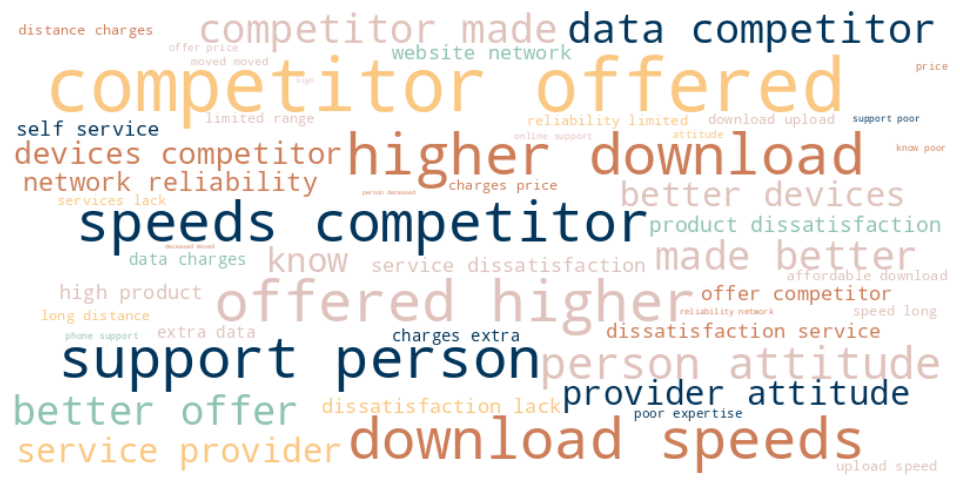

In [29]:
# @title Churn Reason Word Cloud

# collect all reasons
reasons = '\n'.join(df['ChurnReason'].dropna()).lower()

random.seed(49)  # we like this set of colors!

# generate word coloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    mode='RGB',
    prefer_horizontal=1,
    normalize_plurals=True,
    random_state=4,
    color_func=lambda *a, **kw: random.choice(custom_colors),
).generate(reasons)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.tight_layout()
plt.show()

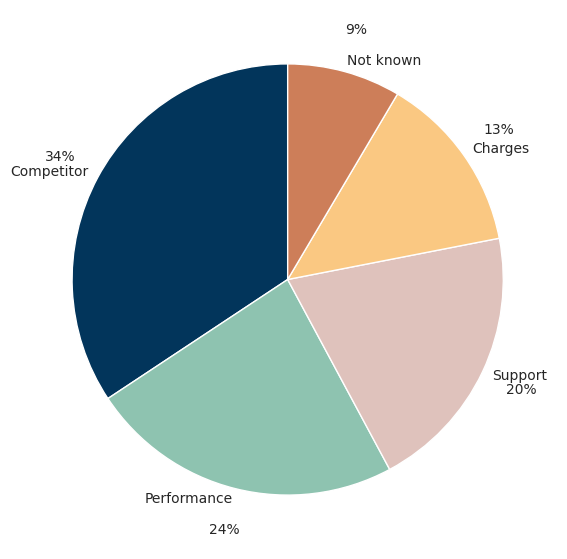

In [30]:
# @title General Churn Reason Pie Chart
plt.figure(figsize=(10, 7))
(df_fe.loc[df_fe['ComprehensiveChurnReason']!='Not Churned', 'ComprehensiveChurnReason']
    .value_counts()
    .plot
    .pie(autopct='%.0f%%', startangle=90, pctdistance=1.2, labeldistance=1.05)
)
plt.ylabel('')
plt.show()

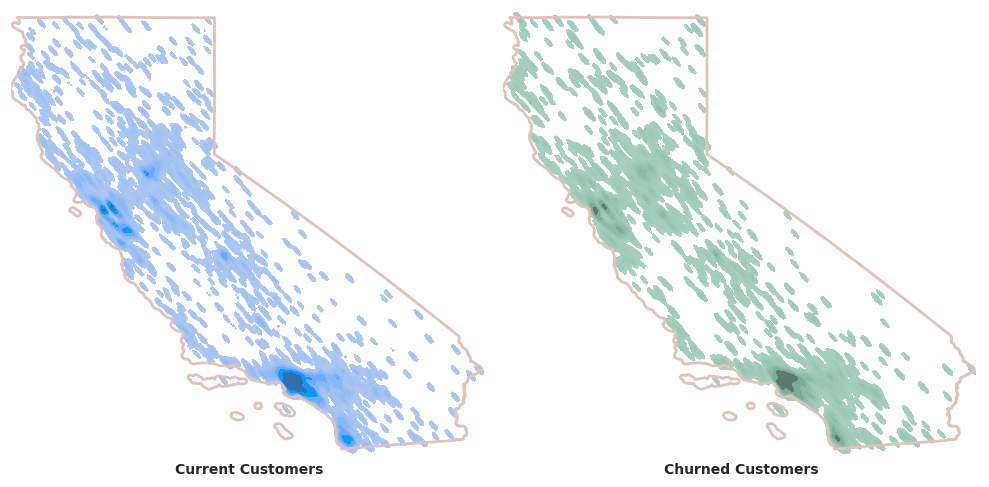

In [31]:
# @title Churn vs Current Customers by Area
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
fig.set_facecolor('white')

axs[0].set_xlabel("Current Customers", **label_kwargs)
axs[1].set_xlabel("Churned Customers", **label_kwargs)
axs[0].set_ylabel("")
axs[0].set_xticks([])
axs[0].set_yticks([])

for n in [0, 1]:
    sns.kdeplot(
        df[df['ChurnValue']==n],
        x='Longitude',
        y='Latitude',
        color=sns.color_palette()[n],
        bw_adjust=0.1,
        fill=True,
        ax=axs[n],
    )
    axs[n].set_facecolor('white')
    axs[n].grid(False)
    axs[n].set_aspect('equal')
    plot_california(axs[n], color=sns.color_palette()[2], alpha=1.0, linewidth=2.0)

plt.tight_layout()
plt.show()

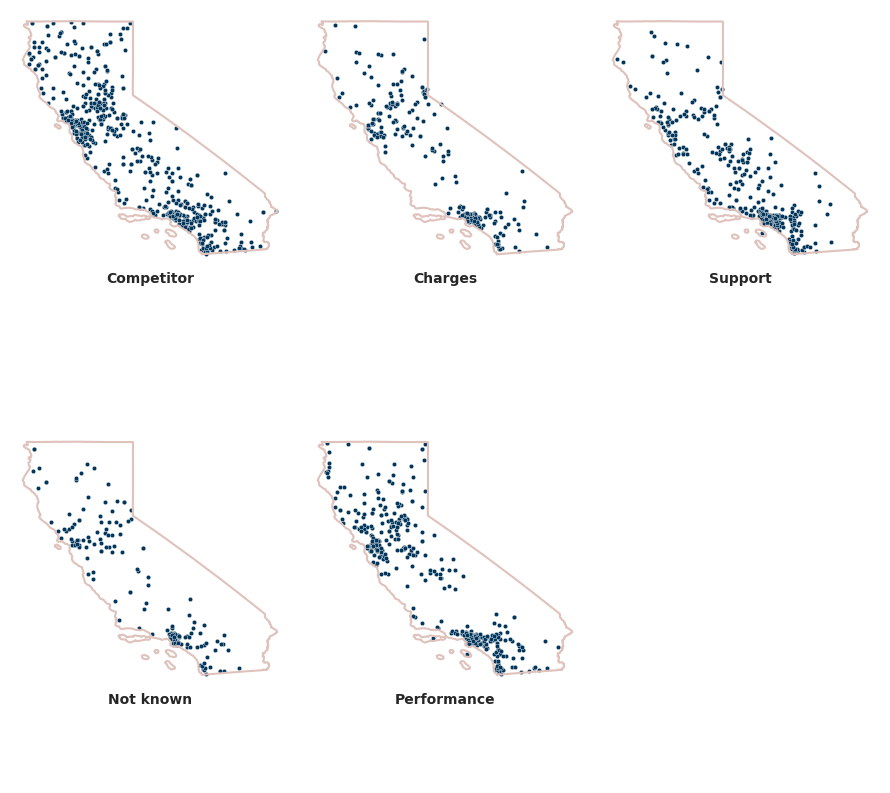

In [32]:
# @title Geographic Distribution of General Churn Reason
fig, axs = plt.subplots(2, 3, figsize=(9, 9), sharey=True)

for n, reason in enumerate(set(df_fe['ComprehensiveChurnReason'].dropna()) - {'Not Churned'}):
    i,j = divmod(n, 3)
    sns.scatterplot(
        y=df_fe.loc[df_fe['ComprehensiveChurnReason']==reason, 'Latitude'],
        x=df_fe.loc[df_fe['ComprehensiveChurnReason']==reason, 'Longitude'],
        color=sns.color_palette()[0],
        s=10,
        legend=False,
        ax=axs[i, j],
    )
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].set_ylabel("")
    axs[i, j].set_xlabel(reason, **label_kwargs)
    axs[i, j].set_aspect('equal')
    axs[i, j].set_facecolor('white')
    plot_california(axs[i, j], color=sns.color_palette()[2])

axs[1, 2].set_xticks([])
axs[1, 2].set_facecolor('white')

plt.tight_layout()
plt.show()

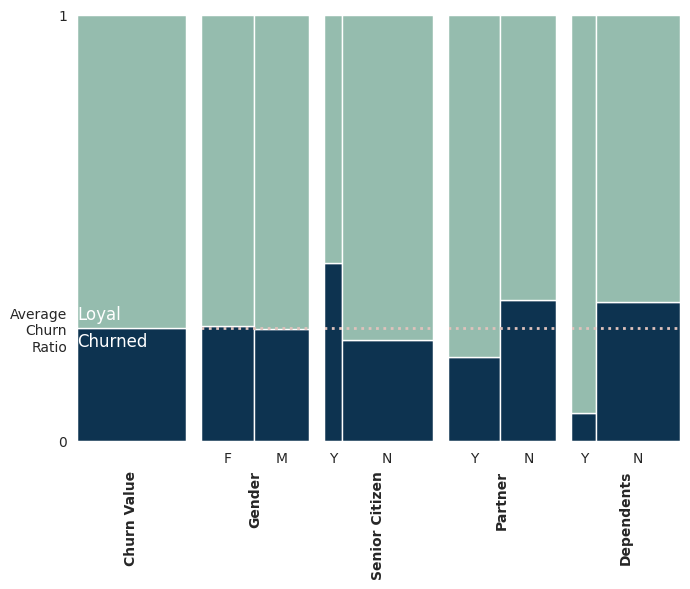

In [33]:
# @title Customer Demographics
churn_rate = df['ChurnValue'].mean()

plot_features = {
    'ChurnValue': [' '],
    'Gender': ['F', 'M'],
    'SeniorCitizen': ['Y', 'N'],
    'Partner': ['Y', 'N'],
    'Dependents': ['Y', 'N'],
}

# generate the plots
fig, axs = plt.subplots(
    1, len(plot_features),
    figsize=(7, 6),
    sharey=True,
)

for n, (feature, xticklabels) in enumerate(plot_features.items()):
    treemap(axs[n], df, feature, "ChurnValue", dropna=False)
    axs[n].set_xticklabels(xticklabels)
    axs[n].set_yticks([0, churn_rate, 1], [0, 'Average\nChurn\nRatio', 1])
    axs[n].grid(visible=False, axis="both")
    if n > 0:
        axs[n].axhline(churn_rate, **axhline_kwargs)
    feature = re.sub(r'(\w)([A-Z])', r'\1 \2', feature)
    axs[n].set_xlabel(feature, rotation=90, fontweight='bold')

axs[0].annotate('Churned', (0.005, churn_rate - 0.01), va='top', color='white', size=12, xycoords='axes fraction')
axs[0].annotate('Loyal', (0.005, churn_rate + 0.01), va='bottom', color='white', size=12, xycoords='axes fraction')

plt.tight_layout()
plt.show()

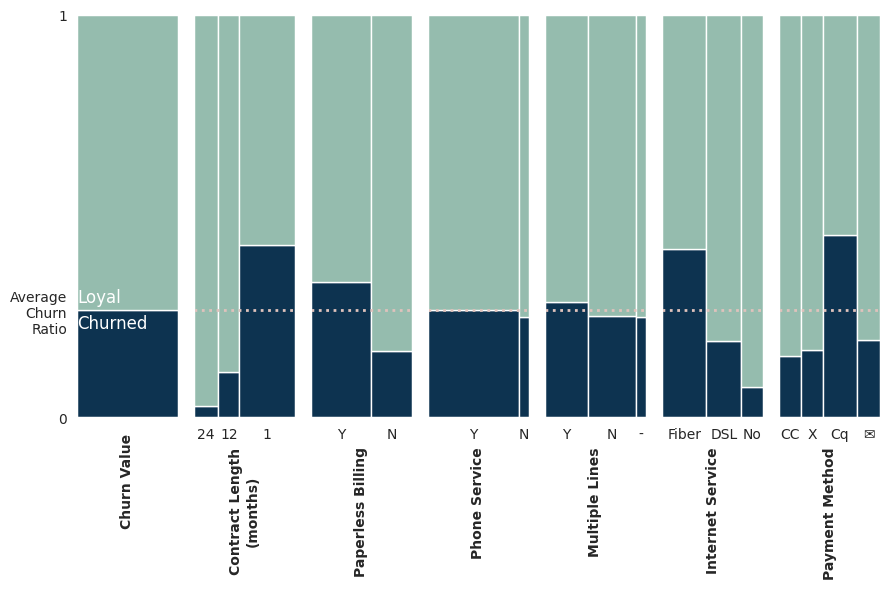

In [34]:
# @title Contract Type Churn Rate
churn_rate = df['ChurnValue'].mean()

plot_features = {
    'ChurnValue': [""],
    'Contract': [24, 12, 1],
    'PaperlessBilling': ["Y", "N"],
    'PhoneService': ["Y", "N"],
    'MultipleLines': ["Y", "N", "-"],
    'InternetService': ['Fiber', 'DSL', 'No'],
    'PaymentMethod': ['CC', 'Xf', 'Cq', '✉'],
}
 #{'Mailed check':0, 'Electronic check':1, 'Bank transfer (automatic)':2, 'Credit card (automatic)':3}

# generate the plots
fig, axs = plt.subplots(
    1, len(plot_features),
    figsize=(9, 6),
    sharey=True,
)

axs[0].set_yticks([0, churn_rate, 1], [0, 'Average\nChurn\nRatio', 1])
for n, (feature, xticklabels) in enumerate(plot_features.items()):
    treemap(axs[n], df, feature, "ChurnValue", dropna=False)
    if n > 0:
          axs[n].axhline(churn_rate, **axhline_kwargs)
    axs[n].set_xticklabels(xticklabels)
    if feature=="Contract":
        feature = "Contract Length\n(months)"
    axs[n].grid(visible=False, axis="both")
    axs[n].set_xlabel(re.sub(r'(\w)([A-Z])', r'\1 \2', feature), rotation=90, fontweight='bold')

axs[0].annotate('Churned', (0.005, churn_rate - 0.01), va='top', color='white', size=12, xycoords='axes fraction')
axs[0].annotate('Loyal', (0.005, churn_rate + 0.01), va='bottom', color='white', size=12, xycoords='axes fraction')

plt.tight_layout()
plt.show()

- CC = credit card
- Xf = transfer
- Cq = cheque (electronic)
- ✉ = cheque (mail)

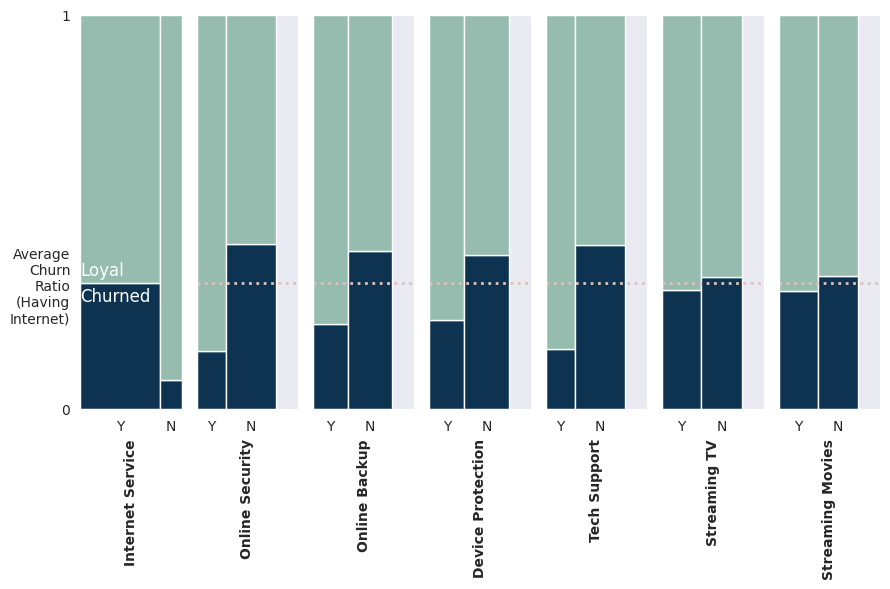

In [35]:
# @title Internet Feature Churn Rate
internet_churn_rate = df.dropna(subset="OnlineSecurity")['ChurnValue'].mean()

# select featues
plot_features = {
    'OnlineSecurity': ['Y', 'N'],
    'OnlineBackup': ['Y', 'N'],
    'DeviceProtection': ['Y', 'N'],
    'TechSupport': ['Y', 'N'],
    'StreamingTV': ['Y', 'N'],
    'StreamingMovies': ['Y', 'N'],
}

# generate the plots
fig, axs = plt.subplots(
    1, len(plot_features) + 1,
    figsize=(9, 6),
    sharey=True,
)

# convert internet service to bool
internet_service_plot = df['OnlineSecurity'].notna().astype("uint8").to_frame('InternetService')
internet_service_plot['ChurnValue'] = df['ChurnValue']
internet_service_plot

# left hand treemap
treemap(axs[0], internet_service_plot, 'InternetService', "ChurnValue", dropna=True)
axs[0].set_yticks([0, churn_rate, 1], [0, 'Churn', 1])
axs[0].set_yticks([0, internet_churn_rate, 1], [0, 'Average\nChurn\nRatio\n(Having\nInternet)', 1])
axs[0].set_xlabel('Internet Service', rotation=90, **label_kwargs)
axs[0].set_xticklabels(['Y', 'N'])

# other treemaps
for n, (feature, xticklabels) in enumerate(plot_features.items()):
    n += 1
    treemap(axs[n], df, feature, "ChurnValue", dropna=True)
    axs[n].set_xticklabels(xticklabels)
    axs[n].grid(visible=False, axis="both")
    if n > 0:
         axs[n].axhline(internet_churn_rate, **axhline_kwargs)
    feature = re.sub(r'(\w)([A-Z])', r'\1 \2', feature)
    axs[n].set_xlabel(feature, rotation=90, **label_kwargs)

axs[0].annotate('Churned', (0.005, internet_churn_rate - 0.01), va='top', color='white', size=12, xycoords='axes fraction')
axs[0].annotate('Loyal', (0.005, internet_churn_rate + 0.01), va='bottom', color='white', size=12, xycoords='axes fraction')

plt.tight_layout()
plt.show()

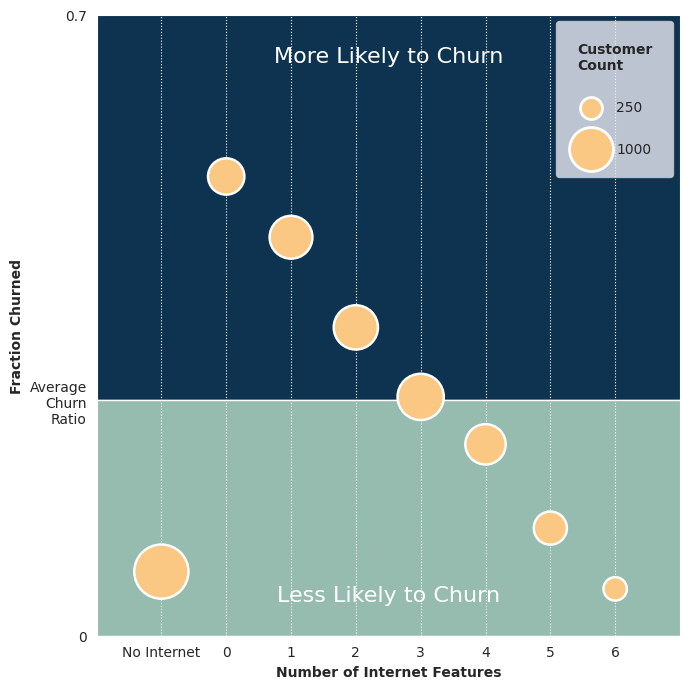

In [36]:
# @title Internet Feature Count Churn Rate

fig, ax = plt.subplots(figsize=(7, 7))
sns.scatterplot(
    df_fe.fillna(-1).groupby('InternetServiceCount')['ChurnValue'].mean().reset_index(),
    x='InternetServiceCount',
    y='ChurnValue',
    s=df_fe.fillna(-1).groupby('InternetServiceCount')['ChurnValue'].count(),
    color=sns.color_palette()[3],
    ax=ax,
)

sns.barplot(x=[2.5], y=[1-churn_rate], width=[10], bottom=[churn_rate], native_scale=True, ax=ax, zorder=-10)
sns.barplot(x=[2.5], y=[churn_rate], width=[10], bottom=[0], native_scale=True, ax=ax, zorder=-10)
ax.set_ylim((0, 0.7))
ax.set_xlim((-2, 7))
ax.set_xticks(range(-1, 7))
ax.set_xticklabels(['No Internet'] + list(range(7)))

# https://jakevdp.github.io/PythonDataScienceHandbook/04.06-customizing-legends.html
for area in [250, 1000]:
    ax.scatter([], [], color=sns.color_palette()[3], s=area, label=str(area), edgecolor="white", linewidth=2.0, )
    ax.legend(scatterpoints=1, frameon=True, labelspacing=2.0, title='Customer\nCount', title_fontproperties={'weight': 'bold'}, borderpad=1.5, )


ax.set_ylabel("Fraction Churned", **label_kwargs)
ax.set_xlabel("Number of Internet Features", **label_kwargs)
ax.set_yticks([0, churn_rate, 0.7], [0, 'Average\nChurn\nRatio', 0.7])
ax.grid(visible=False, axis='y')
ax.grid(visible=True, axis='x', linestyle=":")

ax.annotate('More Likely to Churn', (0.5, 0.95), va='top', color='white', size=16, xycoords='axes fraction', ha="center")
ax.annotate('Less Likely to Churn', (0.5, 0.05), va='bottom',color='white', size=16, xycoords='axes fraction', ha="center")

plt.tight_layout()
plt.show()

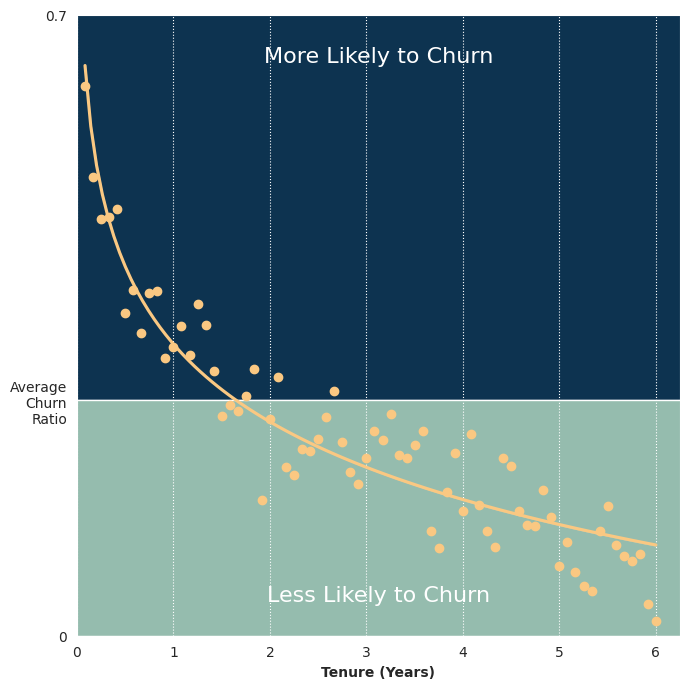

In [37]:
# @title Tenure Time Churn Ratio
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_ylim((0.0, 0.7))
ax.set_xlim((0, 75))
ax.set_xticks([12 * n for n in range(7)], range(7))

sns.barplot(x=[36], y=[1-churn_rate], width=[100], bottom=[churn_rate], native_scale=True, ax=ax, zorder=-10)
sns.barplot(x=[36], y=[churn_rate], width=[100], bottom=[0], native_scale=True, ax=ax, zorder=-10)

sns.regplot(
    df[df['TenureMonths']>0].groupby('TenureMonths')['ChurnValue'].mean().reset_index(),
    x="TenureMonths",
    y="ChurnValue",
    logx=True,
    truncate=True,
    scatter_kws={
        'alpha': 1.0,
        'color': sns.color_palette()[3],
    },
    line_kws={
        'alpha': 1.0,
        'color': sns.color_palette()[3],
    },
    ci=False,
    ax=ax,
)
ax.set_ylabel("", **label_kwargs)
ax.set_xlabel('Tenure (Years)', **label_kwargs)
ax.set_yticks([0, churn_rate, 0.7], [0, 'Average\nChurn\nRatio', 0.7])
ax.grid(visible=False, axis='y')
ax.grid(visible=True, axis='x', linestyle=":")

ax.annotate('More Likely to Churn', (0.5, 0.95), va='top', color='white', size=16, xycoords='axes fraction', ha="center")
ax.annotate('Less Likely to Churn', (0.5, 0.05), va='bottom',color='white', size=16, xycoords='axes fraction', ha="center")

plt.tight_layout()
plt.show()

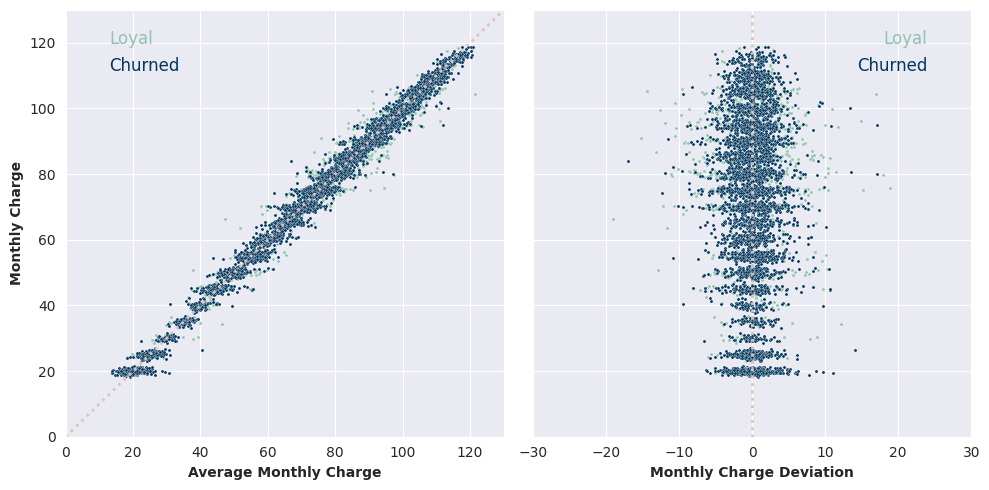

In [38]:
# @title Charges vs Monthly Bill
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for n in [1, 0]:
    sns.scatterplot(
        x=df_fe.loc[df_fe["ChurnValue"]==n, 'AverageCharges'],
        y=df_fe.loc[df_fe["ChurnValue"]==n, 'MonthlyCharges'],
        legend=None,
        color=sns.color_palette()[n],
        s=5,
        ax=axs[0],
    )
axs[0].set_xlabel('Average Monthly Charge', **label_kwargs)
axs[0].set_ylabel('Monthly Charge', **label_kwargs)
axs[0].set_xlim((0, 130))
axs[0].set_ylim((0, 130))
axs[0].axline((0,0), slope=1, **axhline_kwargs)

for n in [1, 0]:
    sns.scatterplot(
        x=df_fe.loc[df_fe["ChurnValue"]==n, 'Overcharge'],
        y=df_fe.loc[df_fe["ChurnValue"]==n, 'MonthlyCharges'],
        legend=None,
        color=sns.color_palette()[n],
        s=5,
        ax=axs[1],
    )
axs[1].set_xlabel('Monthly Charge Deviation', **label_kwargs)
axs[1].set_ylabel('Monthly Charge', **label_kwargs)
axs[1].set_xlim((-30, 30))
axs[1].set_ylim((0, 130))
axs[1].axvline(0, **axhline_kwargs)

axs[0].annotate('Churned', (0.1, 0.9 - 0.01), va='top', color=sns.color_palette()[0], size=12, xycoords='axes fraction')
axs[0].annotate('Loyal', (0.1, 0.9 + 0.01), va='bottom', color=sns.color_palette()[1], size=12, xycoords='axes fraction')
axs[1].annotate('Churned', (0.9, 0.9 - 0.01), va='top', color=sns.color_palette()[0], size=12, xycoords='axes fraction', ha='right')
axs[1].annotate('Loyal', (0.9, 0.9 + 0.01), va='bottom', color=sns.color_palette()[1], size=12, xycoords='axes fraction', ha='right')

plt.tight_layout()
plt.show()

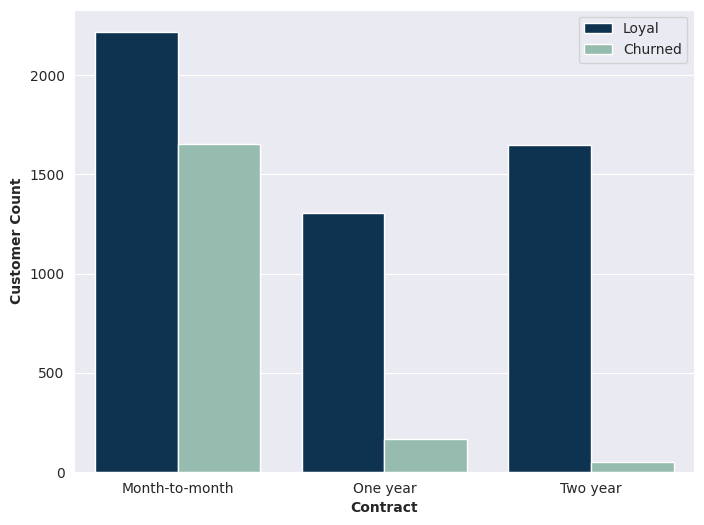

In [39]:
# @title Contract type
fig, ax = plt.subplots(1, figsize=(8, 6))
sns.countplot(data=df, x='Contract', hue='ChurnValue', ax=ax)
ax.set_xlabel('Contract', **label_kwargs)
ax.set_ylabel('Customer Count', **label_kwargs)
ax.set_xticks([0, 1, 2], ['Month-to-month', 'One year', 'Two year'])
ax.legend(['Loyal', 'Churned'])
#plt.set_savefig('Contract.jpg')
plt.show()

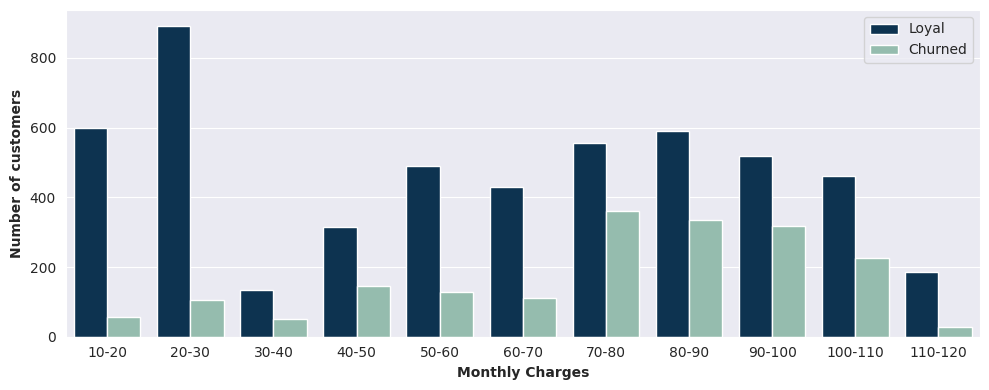

In [40]:
# @title Monthly Charges vs Churning
charges = pd.DataFrame()
charges = df[['MonthlyCharges', 'ChurnValue']].copy()
charges_buckets = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
charges_buckets_name = ['10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100-110', '110-120']
## We pass on our lists as the 'bins' and 'labels' arguments. At the end, we make the new column's type 'category'
charges['category'] = pd.cut(
    charges['MonthlyCharges'],
    bins=charges_buckets,
    labels=charges_buckets_name,
    include_lowest=True,
).astype('category')

fig, ax = plt.subplots(1, figsize=(10, 4))
sns.countplot(data=charges, x='category', hue='ChurnValue')
ax.set_xlabel('Monthly Charges', **label_kwargs)
ax.set_ylabel('Number of customers', **label_kwargs)
ax.legend(['Loyal', 'Churned'])
plt.tight_layout()
#plt.savefig('Monthly Charge.jpg')
plt.show()

#sns.histplot(df, x='MonthlyCharges', hue='ChurnValue', binwidth=10, multiple="dodge", ax=ax)

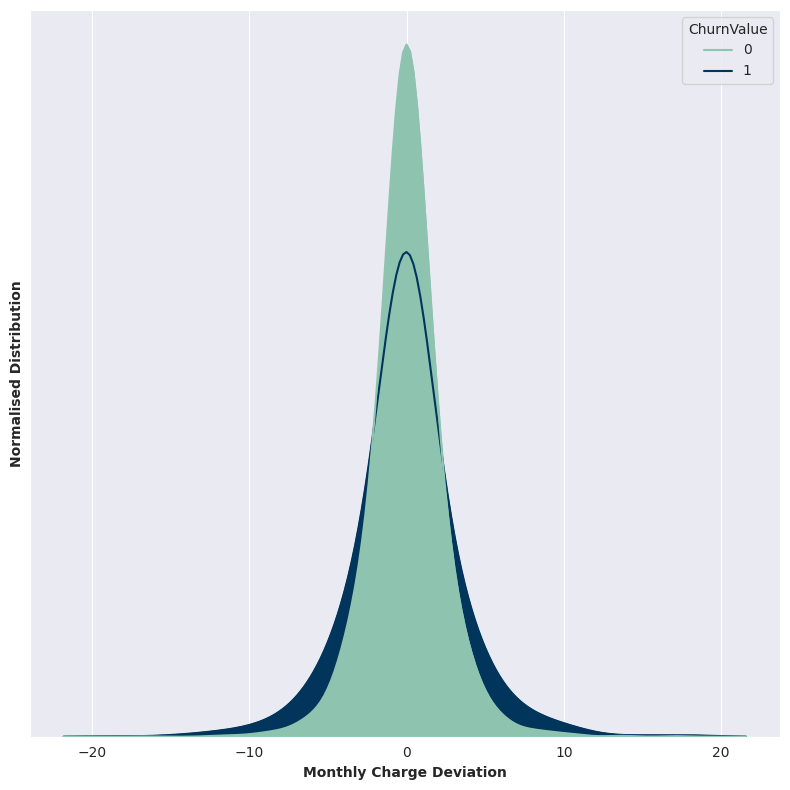

In [41]:
# @title Charges vs Monthly Bill
fig, ax = plt.subplots(1, figsize=(8, 8))

sns.kdeplot(
    df_fe[['ChurnValue', 'Overcharge']].sort_values('Overcharge', ascending=True),
    x='Overcharge',
    bw_adjust=2,
    hue='ChurnValue',
    multiple="layer",
    #cumulative=True,
    common_norm=False,
    common_grid=True,
    palette=sns.color_palette()[1::-1],
    ax=ax,
)
ax.fill_between(
    x =ax.lines[0].get_data()[0],
    y1=ax.lines[0].get_data()[1],
    y2=ax.lines[1].get_data()[1],
    where=ax.lines[0].get_data()[1]>ax.lines[1].get_data()[1],
    color=ax.lines[0].get_color(),
)
ax.fill_between(
    x =ax.lines[0].get_data()[0],
    y1=ax.lines[1].get_data()[1],
    y2=np.zeros(ax.lines[0].get_data()[0].shape[0]),
    #where=ax.lines[0].get_data()[1]<ax.lines[1].get_data()[1],
    color=ax.lines[1].get_color(),
)
ax.set_xlabel('Monthly Charge Deviation', **label_kwargs)
ax.set_ylabel('Normalised Distribution', **label_kwargs)
ax.set_yticks([])

plt.tight_layout()
plt.show()

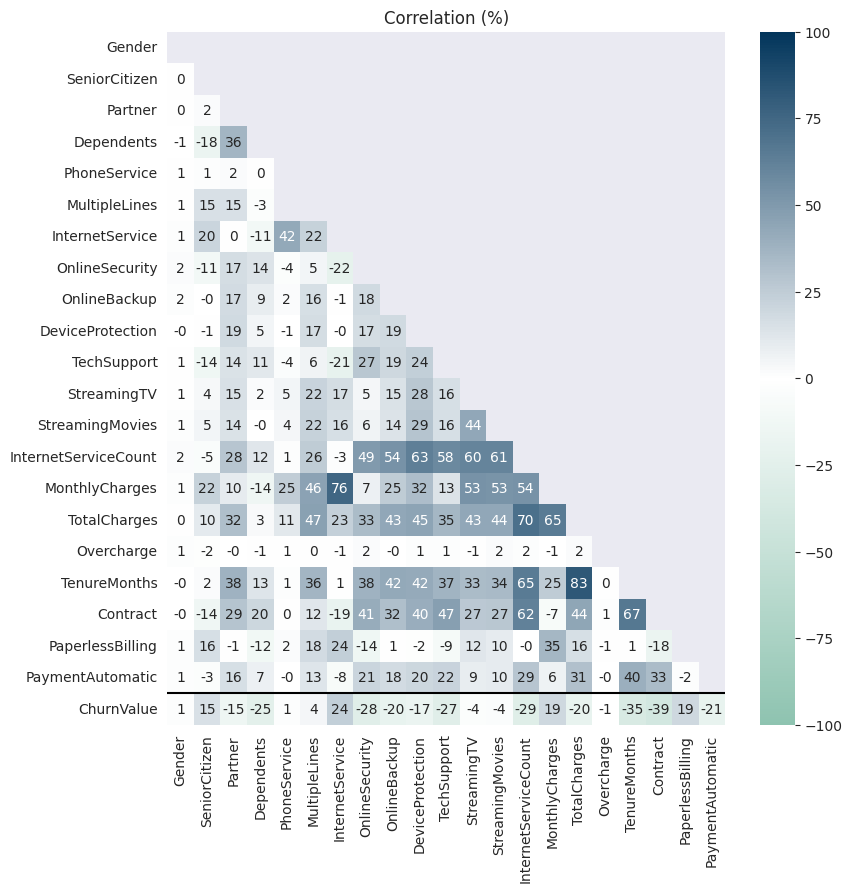

In [42]:
# @title Correlation
corr_pearson = df_fe[[
      'Gender', 'SeniorCitizen', 'Partner', 'Dependents',
      'PhoneService', 'MultipleLines',
      'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
      'InternetServiceCount',
      'MonthlyCharges', 'TotalCharges', 'Overcharge',
      'TenureMonths', 'Contract', 'PaperlessBilling', 'PaymentAutomatic',
      'ChurnValue'
]].corr('pearson', numeric_only=True)

fig, ax = plt.subplots(
    figsize=(9,9),
)
sns.heatmap(
    (corr_pearson * 100).iloc[:, :-1],
    mask=np.triu(np.ones((corr_pearson.shape[0], corr_pearson.shape[1] - 1), dtype="uint8")),
    fmt=".0f",
    cmap=custom_gradient,
    annot=True,
    ax=ax,
    vmin=-100,
    vmax=100,
)
ax.axhline(corr_pearson.shape[0] - 1, color='black')
ax.grid(visible=False, axis="both")
plt.title("Correlation (%)")
plt.show()

---
# Model Design

In [43]:
# available columns
#list(df_fe.columns)

In [44]:
# model building parameters

# select features based uping model scores, collinearity and feature importance
features = [
    #'City',
    #'ZipCode',
    #'Latitude',
    #'Longitude',
    #
    #'Gender',
    #'SeniorCitizen',
    #'Partner',
    'Dependents',
    #
    #'PhoneService',
    #'MultipleLines',
    'InternetServiceCount',
    #'InternetService',
    #'OnlineSecurity',
    #'TechSupport',
    #'OnlineBackup',
    #'DeviceProtection',
    #'StreamingTV',
    #'StreamingMovies',
    #
    'Contract',
    'TenureMonths',
    'PaperlessBilling',
    'PaymentMethod',
    #'PaymentAutomatic',
    #
    #'TotalCharges',
    'MonthlyCharges',
    #'Overcharge',
    #'OverchargeRatio',
    #'AverageCharges',
    #
    #'ComprehensiveChurnReason',
    #'ComprehensiveChurnReasonMapped'
    #'ChurnReason',
    #'ChurnValue',
]

target_label = 'ChurnValue'

tuning_method = 'accuracy' # 'recall'
# recall for 500 list
# accuracy for score
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

cv_params = {
    'cv': 5,
    'refit': True,
    'verbose': 1,
    'scoring': tuning_method,
}

# N.B. put the "favourite" first
decision_tree_param_grid={
    'max_depth': [5, 7, 11], #[5, 2, 3, 4],
    'min_samples_split': [25, 15, 50],
    'min_samples_leaf': [50, 20, 100],
}

# N.B. put the "favourite" first
random_forest_param_grid={
    'n_estimators': [50,],
    'max_depth': [5, 7, 9, 11], #[5, 2, 3, 4],
    'min_samples_split': [25, 15, 50, 100],
    'min_samples_leaf': [50, 20, 100],
}

In [45]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df_fe[features].fillna(-1),
    df_fe[target_label],
    test_size=0.2,
    random_state=987654,
    stratify=df_fe[target_label],
)
assert (X_train.index == y_train.index).all(), 'train-test split error'
assert (X_test.index == y_test.index).all(), 'train-test split error'

# datasets from dataframes
full_ds = tfdf.keras.pd_dataframe_to_tf_dataset(df_fe.fillna(-1), label=target_label)
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_train.join(y_train), label=target_label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_test.join(y_test), label=target_label)

## Modelling and Metrics Functions

In [46]:
def metrics_series(y_true, y_pred, **series_kwargs):
    """return a pd.Series of metrics"""
    return pd.Series(
        {
            'accuracy': metrics.accuracy_score(y_true, y_pred),
            'precision': metrics.precision_score(y_true, y_pred),
            'recall': metrics.recall_score(y_true, y_pred),
            'f1': metrics.f1_score(y_true, y_pred),
        },
        dtype=series_kwargs.pop('dtype', float),
        **series_kwargs,
    )

In [47]:
def build_and_tune(model_name, estimator, param_grid, cv_params, X, y):
    """build and tune the desired model"""

    # initial model
    model = estimator(
        random_state=99,
        **{k: v[0] for k, v in param_grid.items()}, # get first parameter in param grid
    ).fit(X, y)

    # initial model metrics
    y_pred = model.predict(X)
    metrics = metrics_series(y, y_pred).to_frame(model_name)

    # hyperparameter tuning
    grid = GridSearchCV(
        estimator=estimator(),
        param_grid=param_grid,
        **cv_params,
    )
    grid.fit(X_train, y_train)
    print(f'Best score: {grid.best_score_:.3f} with params {grid.best_params_}')
    print()

    # feature importance
    display(
        pd.DataFrame(
            {
                'column': features,
                'importance': grid.best_estimator_.feature_importances_,
            },
        )
        .sort_values('importance', ascending=False)
        .set_index('column')
        .style.format('{:.2f}')
    )

    # tuned params
    y_pred = grid.best_estimator_.predict(X)
    metrics = metrics.join(metrics_series(y, y_pred).to_frame(model_name + " Tuned"))

    return grid, metrics

In [48]:
def validate_model(model, X, y, X_test=None, y_test=None, cross_validation_count=5, head=None):
    """get model scores by cross-validation"""
    cv_frame = pd.concat([
        pd.Series(
            cross_val_score(
                model,
                X,
                y,
                cv=cross_validation_count,
                scoring=metric_name,
            ),
            name=metric_name
        )
        for metric_name in ['accuracy', 'precision', 'recall', 'f1']
    ], axis=1)

    # aggregate info about the cross validation
    for agg_name in ['mean', 'std']:
        cv_frame.loc[agg_name] = cv_frame.agg(agg_name, axis=0)

    cv_frame.index = [f'Cross Validation {n+1}' for n in range(cross_validation_count)] + ['Cross Validation Mean', 'Cross Validation Std. Dev.']

    # append the test result
    if X_test is not None and y_test is not None:
        cv_frame.loc['Test'] = metrics_series(y_test, model.predict(X_test))

    if head is not None:
        return pd.concat((head, cv_frame))

    return cv_frame

## Decision Tree

In [49]:
dt_grid, dt_metrics = build_and_tune(
    "Decision Tree",
    DecisionTreeClassifier,
    decision_tree_param_grid,
    cv_params,
    X_train,
    y_train,
)
display(dt_grid.best_estimator_)
dt_metrics.T.style.format('{:.3f}')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best score: 0.800 with params {'max_depth': 11, 'min_samples_leaf': 50, 'min_samples_split': 25}



,importance
column,
Contract,0.47
MonthlyCharges,0.19
TenureMonths,0.19
Dependents,0.09
InternetServiceCount,0.04
PaperlessBilling,0.02
PaymentMethod,0.01


DecisionTreeClassifier(max_depth=11, min_samples_leaf=50, min_samples_split=25)

,accuracy,precision,recall,f1
Decision Tree,0.802,0.658,0.489,0.561
Decision Tree Tuned,0.819,0.687,0.550,0.611


In [50]:
validate_model(
    dt_grid.best_estimator_,
    X_train,
    y_train,
    X_test=X_test,
    y_test=y_test,
    cross_validation_count=4,
    head=dt_metrics.T,
).style.format('{:.3f}')

,accuracy,precision,recall,f1
Decision Tree,0.802,0.658,0.489,0.561
Decision Tree Tuned,0.819,0.687,0.550,0.611
Cross Validation 1,0.807,0.646,0.564,0.602
Cross Validation 2,0.787,0.607,0.503,0.549
Cross Validation 3,0.794,0.649,0.445,0.528
Cross Validation 4,0.809,0.685,0.486,0.569
Cross Validation Mean,0.799,0.647,0.499,0.562
Cross Validation Std. Dev.,0.009,0.028,0.043,0.027
Test,0.795,0.634,0.489,0.552


## Random Forest

In [51]:
rf_grid, rf_metrics = build_and_tune(
    "Random Forest",
    RandomForestClassifier,
    random_forest_param_grid,
    cv_params,
    X_train,
    y_train,
)
display(rf_grid.best_estimator_)
rf_metrics.T.style.format('{:.3f}')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.812 with params {'max_depth': 11, 'min_samples_leaf': 20, 'min_samples_split': 100, 'n_estimators': 50}



,importance
column,
Contract,0.31
TenureMonths,0.24
MonthlyCharges,0.16
Dependents,0.11
InternetServiceCount,0.10
PaymentMethod,0.05
PaperlessBilling,0.03


RandomForestClassifier(max_depth=11, min_samples_leaf=20, min_samples_split=100,
                       n_estimators=50)

,accuracy,precision,recall,f1
Random Forest,0.805,0.719,0.405,0.519
Random Forest Tuned,0.821,0.700,0.539,0.609


In [52]:
validate_model(
    rf_grid.best_estimator_,
    X_train,
    y_train,
    X_test=X_test,
    y_test=y_test,
    cross_validation_count=4,
    head=rf_metrics.T,
).style.format('{:.3f}')

,accuracy,precision,recall,f1
Random Forest,0.805,0.719,0.405,0.519
Random Forest Tuned,0.821,0.700,0.539,0.609
Cross Validation 1,0.817,0.700,0.503,0.593
Cross Validation 2,0.806,0.658,0.517,0.563
Cross Validation 3,0.802,0.667,0.467,0.547
Cross Validation 4,0.820,0.730,0.528,0.605
Cross Validation Mean,0.811,0.689,0.503,0.577
Cross Validation Std. Dev.,0.008,0.029,0.023,0.023
Test,0.800,0.650,0.492,0.560


## Tensorflow

In [53]:
# N.B. put the "favourite" first
tfdf_num_trials=10
tfdf_num_trees=20
tfdf_compile_params = {
    "metrics": [tuning_method],
}

tfdf_global_params = {
    "max_num_nodes": [16, 32, 64, 128],
    "min_examples": [25, 50, 100, ],
}
tfdf_local_params = {
    "max_depth": [4, 7, 9],
}
tfdf_estimator = tfdf.keras.RandomForestModel
#("min_examples", [30, 60])
#tfdf.keras.GradientBoostedTreesModel
#tfdf.keras.RandomForestModel

In [54]:
# build an initial model
tfdf_model = tfdf_estimator(
    **{k: v[0] for k, v in tfdf_global_params.items()}, # get first parameter in param grid
    **{k: v[0] for k, v in tfdf_local_params.items()}, # get first parameter in param grid
    growing_strategy='BEST_FIRST_GLOBAL',
)
tfdf_model.fit(train_ds)
tfdf_model.compile(**tfdf_compile_params)

# evaluate the model performance
#print(tfdf_model.evaluate(train_ds))
tfdf_metrics = metrics_series(y_train, (tfdf_model.predict(train_ds)>0.5).astype(int)).to_frame("Neural Network")
tfdf_metrics.style.format("{:.3f}")

Use /tmp/tmp4xp9r0sn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:10.614983. Found 5587 examples.
Training model...
Model trained in 0:00:01.218427
Compiling model...
Model compiled.
6/6 [==============================] - 0s 14ms/step


,Neural Network
accuracy,0.800
precision,0.706
recall,0.389
f1,0.502


In [55]:
# Tuning
tuner = tfdf.tuner.RandomSearch(num_trials=tfdf_num_trials)
local_search_space = tuner.choice("growing_strategy", ["LOCAL"])
global_search_space = tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"], merge=True)
for choice_name, choice_values in tfdf_local_params.items():
    local_search_space.choice(choice_name, choice_values)
for choice_name, choice_values in tfdf_global_params.items():
    global_search_space.choice(choice_name, choice_values)

# Configure and train the model.
tfdf_model_tuned = tfdf_estimator(tuner=tuner)
tfdf_model_tuned.fit(train_ds)
tfdf_model_tuned.compile(metrics=metrics)

tfdf_tuned_metrics = metrics_series(y_train, (tfdf_model_tuned.predict(train_ds) > 0.5).astype(int)).to_frame("Neural Network Tuned")
tfdf_tuned_metrics.style.format("{:.3f}")

Use /tmp/tmpuykhur5n as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.286669. Found 5587 examples.
Training model...
Model trained in 0:00:15.912836
Compiling model...
Model compiled.
6/6 [==============================] - 0s 28ms/step


,Neural Network Tuned
accuracy,0.819
precision,0.686
recall,0.553
f1,0.613


In [56]:
pd.concat(
    (
        tfdf_metrics,
        tfdf_tuned_metrics,
        metrics_series(y_test, (tfdf_model.predict(test_ds) > 0.5).astype(int)).to_frame("Test Data"),
        metrics_series(y_test, (tfdf_model_tuned.predict(test_ds) > 0.5).astype(int)).to_frame("Test Data, Tuned"),
    ),
    axis=1,
).T.style.format("{:0.3f}")

2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 23ms/step


,accuracy,precision,recall,f1
Neural Network,0.800,0.706,0.389,0.502
Neural Network Tuned,0.819,0.686,0.553,0.613
Test Data,0.780,0.641,0.345,0.449
"Test Data, Tuned",0.801,0.652,0.497,0.564


---
# Model Interpretation

In [57]:
# gather feature importance
feature_importance = pd.concat(
    (
        pd.DataFrame(
            {
                'Feature': dt_grid.feature_names_in_,
                'Importance': dt_grid.best_estimator_.feature_importances_,
                'Model': ['Decision Tree'] * len(features),
            }
        ),
        pd.DataFrame(
            {
                'Feature': rf_grid.feature_names_in_,
                'Importance': rf_grid.best_estimator_.feature_importances_,
                'Model': ['Random Forest'] * len(features),
            }
        ),
        pd.DataFrame(
            [(f[0].name, f[1], 'Neural Network') for f in tfdf_model.make_inspector().variable_importances()["SUM_SCORE"]],
            columns=['Feature', 'Importance', 'Model'],
        )
    )
)

feature_importance.loc[feature_importance['Model']=='Neural Network', 'Importance'] = (
    feature_importance.loc[feature_importance['Model']=='Neural Network', 'Importance']
    / feature_importance.loc[feature_importance['Model']=='Neural Network', 'Importance'].sum()
)
feature_importance.sort_values('Importance', ascending=False, inplace=True)

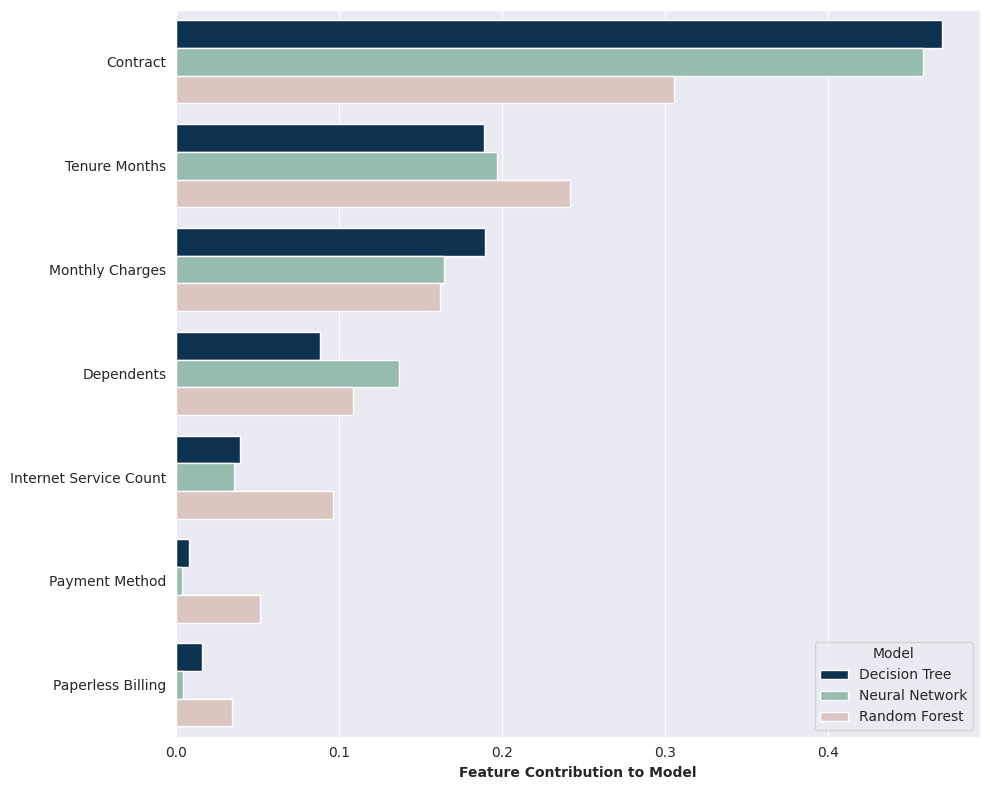

In [58]:
# @title Bar Chart
fig, ax = plt.subplots(1, figsize=(10, 8))
sns.barplot(feature_importance, x='Importance', y='Feature', hue='Model', ax=ax)
ax.set_xlabel('Feature Contribution to Model', **label_kwargs)
ax.set_ylabel(None)
ax.set_yticks(range(len(features)))
ax.set_yticklabels([re.sub(r'(\w)([A-Z])', r'\1 \2', feature) for feature in feature_importance['Feature'].unique()])
plt.tight_layout()
plt.show()

In [59]:
# @title Sankey Diagram
model_names = list(feature_importance['Model'].unique())

sankey_label = (
    list(feature_importance['Feature'].unique())
    + model_names
    + ['Churn', 'Loyal']
)
sankey_source = list()
sankey_target = list()
sankey_value = list()
sankey_color = list()


# load importance
for _, (feature, importance, model) in feature_importance.iterrows():
    sankey_source.append(sankey_label.index(feature))
    sankey_target.append(sankey_label.index(model))
    sankey_value.append(importance)
    sankey_color.append(custom_colors[2 + model_names.index(model)])


#TODO MUST GET TH REAL VALUES!!
# load model predictions
for model, churn_ratio in {
    'Neural Network': 0.2,
    'Decision Tree': dt_grid.best_estimator_.predict(df_fe[features].fillna(-1)).mean(),
    'Random Forest': rf_grid.best_estimator_.predict(df_fe[features].fillna(-1)).mean(),
}.items():
    sankey_source.append(sankey_label.index(model))
    sankey_target.append(sankey_label.index("Churn"))
    sankey_value.append(churn_ratio)
    sankey_color.append(custom_colors[0])
    sankey_source.append(sankey_label.index(model))
    sankey_target.append(sankey_label.index("Loyal"))
    sankey_value.append(1 - churn_ratio)
    sankey_color.append(custom_colors[1])


sankey_label = (
    list(feature_importance['Feature'].str.replace(r'(\w)([A-Z])', r'\1 \2', regex=True).unique())
    + list(feature_importance['Model'].unique())
    + ['Churn', 'Loyal']
)

fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=20,
      thickness=10,
      line=dict(color="white", width=1.0),
      label=sankey_label,
      color=(['black'] * 13),#feature_importance['Feature'].nunique()) + [custom_colors[n] for n in [5, 3, 4, 0, 1]],
    ),
    link=dict(
      source=sankey_source,
      target=sankey_target,
      value=sankey_value,
      color=sankey_color,
    ),
    textfont=dict(
      size=15,
      color='black',
    ),
)])

fig.show()

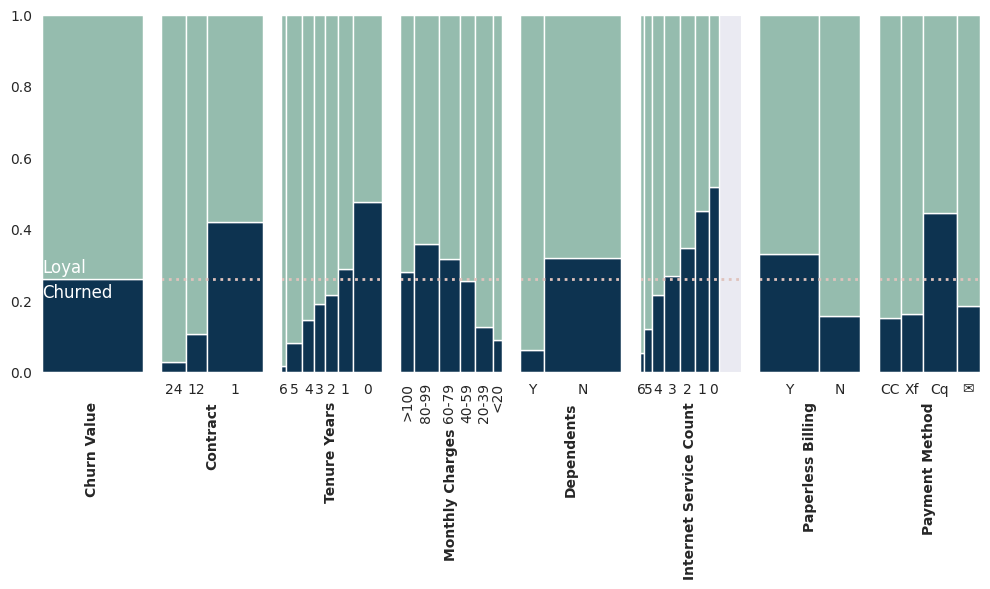

In [60]:
# @title Important Feature Churn Rate
churn_rate = df_fe['ChurnValue'].mean()

# select featues
plot_features = {
    'ChurnValue': [' '],
    'Contract': [24, 12, 1],
    'TenureMonths': [6, 5, 4, 3, 2, 1, 0],
    'MonthlyCharges': ['>100', '80-99', '60-79', '40-59', '20-39', '<20'],
    'Dependents': ['Y', 'N'],
    'InternetServiceCount': [6, 5, 4, 3, 2, 1, 0],
    'PaperlessBilling': ['Y', 'N'],
    'PaymentMethod': ['CC', 'Xf', 'Cq', '✉'],
}

df_plot = df_fe[plot_features.keys()].copy()
df_plot['TenureMonths'] = (df_plot['TenureMonths']/12).astype(int)
df_plot['MonthlyCharges'] = (df_plot['MonthlyCharges']/20).astype(int)


# generate the plots
fig, axs = plt.subplots(
    1, len(plot_features),
    figsize=(10, 6),
    sharey=True,
)

for n, (feature, axislabels) in enumerate(plot_features.items()):
    treemap(axs[n], df_plot, feature, "ChurnValue", dropna=True)
    rotation = None
    if feature == 'MonthlyCharges':
        rotation='vertical'
    axs[n].set_xticklabels(axislabels, rotation=rotation)
    axs[n].grid(visible=False, axis="both")
    if n > 0:
         axs[n].axhline(churn_rate, **axhline_kwargs)
    feature = re.sub(r'(\w)([A-Z])', r'\1 \2', feature)
    feature = feature.replace(' Months', ' Years')
    axs[n].set_xlabel(feature, rotation=90, **label_kwargs)

axs[0].annotate('Churned', (0.005, churn_rate - 0.01), va='top', color='white', size=12, xycoords='axes fraction')
axs[0].annotate('Loyal', (0.005, churn_rate + 0.01), va='bottom', color='white', size=12, xycoords='axes fraction')

plt.tight_layout()
plt.show()

## Staff Incentive
- Customers who already have been customers for a long time [__tenure months__] with __dependents__ and low __monthly charges__ are more likely to stay with the company.
- The most valuable features to reduce churn are increased __contract__ length (promote 2-year or 1-year over rolling contracts) and increased numbers of __internet services__. In general more services are better and more than 3 is ideal, with the most important being __online security__ and __tech support__.
- Customer should also be encouraged to adopt paperless billing and avoid payment using electronic cheque transfer.
- __Recommendation__: $2.50 feature signup incentive. Upon sign-up, to reduce the customers churn liklihood, incentives should be given for 24-month contracts.


---
# Churn Calculations

## Churn Score

- Tune models with focus on __ACCURACY__ $\therefore$ select __Random Forest__
- Convert score to easy to use range: 1 (lowest) to 10 (highest)
- Ordered by CustomerID

In [61]:
# get predictions
prediction_score = pd.DataFrame(
    {
        'Score': rf_grid.best_estimator_.predict_proba(df_fe[features].fillna(-1))[:, 1],
        'actual': df_fe['ChurnValue'].copy(),
    }
)
# retreive index from orginal df
prediction_score.index = df_fe.index
prediction_score.sort_index(inplace=True)
prediction_score.drop(prediction_score[prediction_score['actual']==1].index, inplace=True)
churn_score = 1 + (10.0 * prediction_score['Score']).pipe(np.floor).astype(int)
churn_score

CustomerID
0002-ORFBO    2
0003-MKNFE    3
0013-MHZWF    3
0013-SMEOE    2
0014-BMAQU    1
             ..
9979-RGMZT    4
9987-LUTYD    2
9992-UJOEL    5
9993-LHIEB    1
9995-HOTOH    1
Name: Score, Length: 5174, dtype: int64

In [62]:
# Export
pd.Series(churn_score).to_csv(f'Willow_CustomerChurnScore_{datetime.datetime.now().strftime("%H%M")}.csv')

## 500 Customers Most Likely to Churn

- Tune models with focus on __RECALL__ $\therefore$ select __Decision Tree__

In [63]:
# selected params for 500
# tuned based on altering parameters above
#features = ['Dependents', 'InternetServiceCount', 'Contract', 'TenureMonths', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']
decision_tree_param_grid = {  # just one set of params - preselected from before
    'max_depth': [7],
    'min_samples_leaf': [20],
    'min_samples_split': [50],
}

target_label = 'ChurnValue'
tuning_method = 'recall' # want good recall fo find all churn risk customers
cv_params = {
    'cv': 5,
    'refit': True,
    'verbose': 1,
    'scoring': tuning_method,
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
}

In [64]:
dt_grid, dt_metrics = build_and_tune(
    "Decision Tree",
    DecisionTreeClassifier,
    decision_tree_param_grid,
    cv_params,
    X_train,
    y_train,
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best score: 0.538 with params {'max_depth': 7, 'min_samples_leaf': 20, 'min_samples_split': 50}



,importance
column,
Contract,0.47
TenureMonths,0.19
MonthlyCharges,0.19
Dependents,0.09
InternetServiceCount,0.03
PaperlessBilling,0.02
PaymentMethod,0.01


In [65]:
validate_model(
    dt_grid.best_estimator_,
    X_train,
    y_train,
    X_test=X_test,
    y_test=y_test,
    cross_validation_count=4,
    head=dt_metrics.T,
).style.format('{:.3f}')

,accuracy,precision,recall,f1
Decision Tree,0.815,0.695,0.513,0.590
Decision Tree Tuned,0.815,0.695,0.513,0.590
Cross Validation 1,0.802,0.632,0.561,0.594
Cross Validation 2,0.785,0.615,0.450,0.520
Cross Validation 3,0.792,0.637,0.461,0.535
Cross Validation 4,0.807,0.645,0.566,0.603
Cross Validation Mean,0.796,0.632,0.510,0.563
Cross Validation Std. Dev.,0.008,0.011,0.054,0.036
Test,0.791,0.636,0.453,0.529


In [66]:
# get all predictions
prediction_500 = pd.DataFrame(
    {
        'predicted_dt': dt_grid.best_estimator_.predict_proba(df_fe[features].fillna(-1))[:, 1],
        'actual': df_fe['ChurnValue'].copy(),
    }
)
# retreive index from orginal df
prediction_500.index = df_fe.index

In [67]:
prediction_500.drop(prediction_500[prediction_500['actual']==1].index, inplace=True)
churn_500 = prediction_500['predicted_dt'].sort_values(ascending=False).head(500).index
churn_500

Index(['2254-DLXRI', '1628-BIZYP', '1393-IMKZG', '7577-SWIFR', '4912-PIGUY',
       '2792-LSHWX', '7439-DKZTW', '8903-WMRNW', '4298-OYIFC', '7379-FNIUJ',
       ...
       '3692-JHONH', '5897-ZYEKH', '2806-MLNTI', '4753-PADAS', '5285-MVEHD',
       '0565-JUPYD', '6408-OTUBZ', '0471-ARVMX', '5074-FBGHB', '2560-PPCHE'],
      dtype='object', name='CustomerID', length=500)

In [68]:
df_fe.loc[churn_500].head()  # looks ok!

,City,ZipCode,Latitude,Longitude,Gender,SeniorCitizen,Partner,Dependents,TenureMonths,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ChurnValue,ChurnReason,AverageCharges,Overcharge,OverchargeRatio,InternetServiceCount,PaymentAutomatic,ComprehensiveChurnReason,ComprehensiveChurnReasonMapped
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2254-DLXRI,Burbank,91504,34.213049,-118.317651,1,0,0,0,1,1,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0,79.15,79.15,0,Not Churned,79.15,0.0,0.0,1.0,0,Not Churned,NaN
1628-BIZYP,Brentwood,94513,37.908242,-121.682472,0,0,0,0,1,1,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,1,85.00,85.00,0,Not Churned,85.00,0.0,0.0,2.0,0,Not Churned,NaN
1393-IMKZG,Fullerton,92831,33.879983,-117.895482,1,0,0,0,1,1,0.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1,1,1,95.85,95.85,0,Not Churned,95.85,0.0,0.0,3.0,0,Not Churned,NaN
7577-SWIFR,Glendale,91206,34.162515,-118.203869,0,0,0,0,1,1,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1,1,1,89.25,89.25,0,Not Churned,89.25,0.0,0.0,2.0,0,Not Churned,NaN
4912-PIGUY,Perris,92571,33.828289,-117.201666,1,0,0,0,1,1,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,84.60,84.60,0,Not Churned,84.60,0.0,0.0,1.0,0,Not Churned,NaN


__Thank you for working with us!__